5/20 (Mon) | Experiment

# Evaluation of Predictability of Automatically Calculated UF Measures

## 1. Introduction

This notebook evaluate the reliability of the UF measures calculated based on the proposed annotation system. More specifically, I construct linear models to predict PF for each task.

The input variables are follows:
- Speed fluency
    - Articulation rate (AR)
- Breakdown fluency
    - Mid-clause pause ratio (MCPR)
    - End-clause pause ratio (ECPR)
    - Mid-clause pause duration (MCPD)
    - End-clause pause duration (ECPD)
    - Pause ratio (PR)
    - Pause duration (PD)
- Repair fluency
    - Disfluency ratio (DR)
- Composite
    - Speech rate (SR)
    - Mean length of run (MLR)

The output variable is logit value which is calculated by Many Facet Rasch model (i.e., raters' severity is removed).

Linear regressions are employed as prediction models.
The dataset is divided into training and testing at a ratio of 8:2 taking distribution into account.
For the model construction, because of relatively small data size, I utilize the stratified 5-fold cross validation technique.
The models are evaluated in terms of Pearon's correlation coefficient and $R^2$ score.

Before starting the evaluation, the following code block loads required packages and define global variables.

In [1]:
from typing import Tuple, Dict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from utils.mfr import logit_2_rating

DATA_DIR = Path("/home/matsuura/Development/app/feature_extraction_api/experiment/data")

TASK = ["Arg_Oly", "Cartoon", "RtSwithoutRAA", "RtSwithRAA", "WoZ_Interview"]

TARGET_UF_MEASURES = [
    "articulation_rate", "mid_clause_pause_ratio", "end_clause_pause_ratio",
    "mid_clause_p-dur", "end_clause_p-dur", "pause_ratio", "mean_pause_duration",
    "dysfluency_ratio", "speech_rate", "mean_length_of_run"
]

RANDOM_STATE = 0

---

## 2. Define Functions

This section defines functions for the analyses.
The following code block defines functions to load a dataset including UF measures and logit value.

In [2]:
def add_pause_ratio(df_uf: pd.DataFrame) -> pd.DataFrame:
    df_uf.loc[:, "pause_ratio"] = df_uf["mid_clause_pause_ratio"] + df_uf["end_clause_pause_ratio"]

    return df_uf

def calculate_mean_uf_measures(df_uf: pd.DataFrame) -> pd.DataFrame:
    data = []

    for uid in range(1, 86):
        uid = str(uid).zfill(3)

        mask = df_uf.index.str.startswith(uid)
        if mask.sum() == 0:
            continue

        df_uf_masked = df_uf[mask]
        mean_uf_measures = df_uf_masked.mean(axis=0, skipna=True)
        
        row = {
            "uid": uid   
        }
        for measure_name in df_uf.columns:
            row[measure_name] = mean_uf_measures[measure_name]
        data.append(row)

    df_uf_mean = pd.DataFrame.from_dict(data).set_index("uid", drop=True)

    return df_uf_mean

def load_dataset(task: str, manual: bool =True) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if manual:
        uf_path = DATA_DIR / f"{task}/09_UF_Measures/uf_measures_manu_pruned.csv"
    else:
        uf_path = DATA_DIR / f"{task}/09_UF_Measures/uf_measures_auto_pruned.csv"

    df_uf = pd.read_csv(uf_path, index_col="uid")

    if task == "WoZ_Interview":
        df_uf = calculate_mean_uf_measures(df_uf)

    df_uf = add_pause_ratio(df_uf)

    X = df_uf[TARGET_UF_MEASURES].sort_index()

    pf_path = DATA_DIR / f"{task}/12_PF_Rating/pf_rating.csv"
    df_pf = pd.read_csv(pf_path)
    uid_list = df_pf["uid"].to_numpy()

    logit_path = pf_path.parent / "logit.csv"
    threshold_path = logit_path.parent / "threshold.csv"
    
    df_logit = pd.read_csv(logit_path, index_col=0)
    logit = df_logit["theta"].to_numpy()
    rating_list = logit_2_rating(df_logit["theta"], threshold_path)

    data = np.array([uid_list, logit, rating_list]).T
    columns = ["uid", "logit", "rating"]

    Y = pd.DataFrame(data, columns=columns).set_index("uid", drop=True).sort_index()

    return X, Y

The following code block defines a function to conduct correlation analyses between UF measures and logit value.

In [3]:
def correlation_analysis(task: str, X: pd.DataFrame, Y: pd.DataFrame, manual: bool =True) -> pd.DataFrame:
    fig = plt.figure(figsize=(15, 10))
    ncols = 4
    nrows = (len(TARGET_UF_MEASURES) + ncols - 1) // ncols

    data = []
    columns = ["UF measures", "r", "p", "sig"]
    y = Y["logit"]
    for i, measure in enumerate(TARGET_UF_MEASURES):
        ax = fig.add_subplot(nrows, ncols, i + 1)

        x = X[measure]

        r, p = pearsonr(x, y)
        if p < 0.001:
            sig = "***"
        elif p < 0.01:
            sig = "**"
        elif p < 0.05:
            sig = "*"
        elif p < 0.1:
            sig = "."
        else:
            sig = ""

        data.append([measure, r, p, sig])

        ax.scatter(x, y)
        ax.set_title(f"[{measure}] r={r:.03f}{sig}")
        if manual:
            ax.set_xlabel(f"{measure} (manual)")
        else:
            ax.set_xlabel(f"{measure} (automatic)")
        ax.set_ylabel(f"logit value")

    df_pearsonr = pd.DataFrame(data, columns=columns).set_index("UF measures", drop=True)

    if manual:
        fig.suptitle(f"[{task}] Scatter Plots of Manual UF Measures and Logit Value (N={len(X)})", fontweight="bold")
    else:
        fig.suptitle(f"[{task}] Scatter Plots of Automatic UF Measures and Logit Value (N={len(X)})", fontweight="bold")
    fig.tight_layout()
    plt.show()

    return df_pearsonr

The following code block defines a function to train a linear regression model.

In [4]:
def train(X: pd.DataFrame, Y:pd.DataFrame) -> Dict[int, dict]:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    results = {}
    for i, (train_index, test_index) in enumerate(skf.split(X.to_numpy(), Y["rating"].to_numpy(dtype=int))):
        X_train = X.to_numpy()[train_index]
        X_test = X.to_numpy()[test_index] 
        
        Y_train = Y["logit"].to_numpy()[train_index]
        Y_test = Y["logit"].to_numpy()[test_index]

        model = LinearRegression().fit(X_train, Y_train)
        score = model.score(X_train, Y_train)
        Y_pred = model.predict(X_test)

        print(f"[{i}] R2 = {score}")
        results[i] = {
            "model": model,
            "score": score,
            "Y_test": Y_test,
            "Y_pred": Y_pred
        }

    return results

The following code block defines functions to evaluate a trained model.

In [5]:
def evaluate(task: str, results: Dict[int, dict], manual: bool =True) -> pd.DataFrame:
    y_true_list = []
    y_pred_list = []
    r2_list = []
    r_list = []

    data = []
    
    fig = plt.figure(figsize=(20, 10))
    for trial, result in results.items():
        y_true = result["Y_test"]
        y_pred = result["Y_pred"]

        y_true_list.append(y_true)
        y_pred_list.append(y_pred)
        
        ax = fig.add_subplot(2, 3, trial + 1)
        r2 = r2_score(y_true, y_pred)
        r, _ = pearsonr(y_true, y_pred)

        r2_list.append(r2)
        r_list.append(r)
        
        row = {
            "name": f"{trial} trial",
            "R2": r2,
            "r": r
        }
        data.append(row)

        ax.scatter(y_true, y_pred)
        ax.set_title(f"True vs. Predicted Logit Scores (trial={trial}; R2={r2:.03f}; r={r:.03f})")
        ax.set_xlabel(f"True Logit Scores")
        ax.set_ylabel(f"Predicted Logit Scores")

    row = {
        "name": "Average",
        "R2": np.mean(r2_list),
        "r": np.mean(r_list)
    }
    data.append(row)

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    r2 = r2_score(y_true, y_pred)
    r, _ = pearsonr(y_true, y_pred)

    row = {
        "name": "Concat",
        "R2": r2,
        "r": r
    }
    data.append(row)

    ax = fig.add_subplot(2, 3, 6)
    ax.scatter(y_true, y_pred)
    ax.set_title(f"True vs. Predicted Logit Scores (All Trials; R2={r2:.03f}; r={r:.03f})")
    ax.set_xlabel(f"True Logit Scores")
    ax.set_ylabel(f"Predicted Logit Scores")

    if manual:
        fig.suptitle(f"Evaluation of Trained Linear Regression Model (Manual)")
    else:
        fig.suptitle(f"Evaluation of Trained Linear Regression Model (Automatic)")
    fig.tight_layout()
    plt.show()

    df_eval = pd.DataFrame().from_dict(data).set_index("name", drop=True)

    return df_eval

---

## 3. Analyses

This section trains and evaluates linear regression models for each task.

### 3.1. Arg Oly

**Manual Measures**

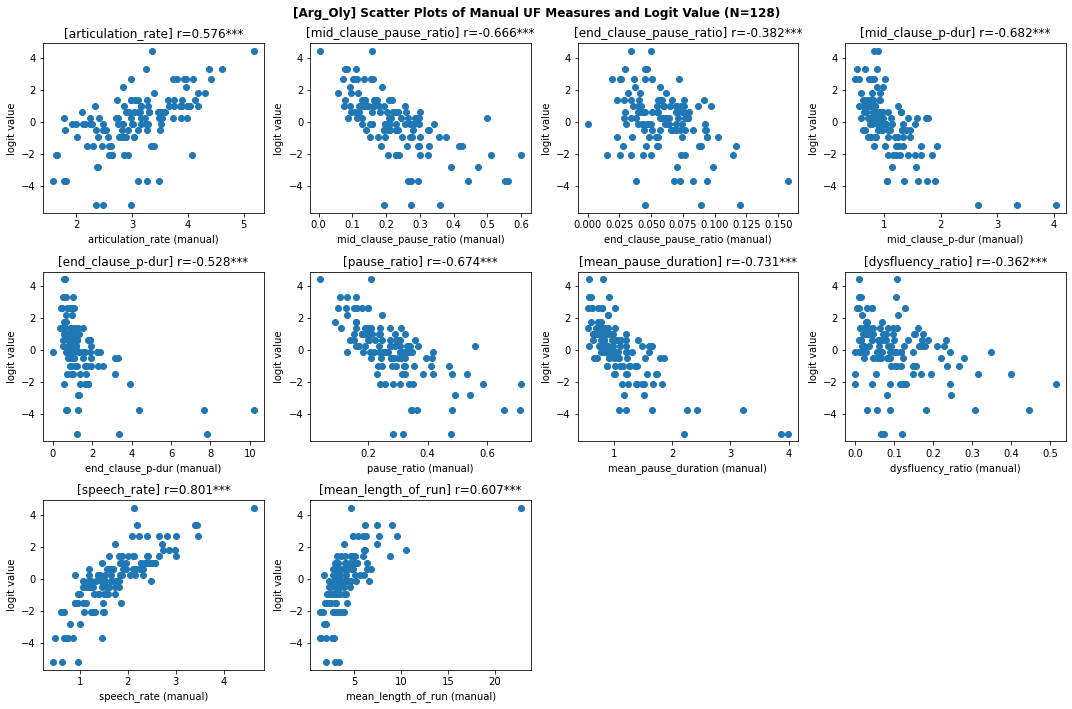

,r,p,sig
UF measures,,,
articulation_rate,0.576119,1.117537e-12,***
mid_clause_pause_ratio,-0.666073,9.549719e-18,***
end_clause_pause_ratio,-0.381752,8.738314e-06,***
mid_clause_p-dur,-0.681527,8.442876e-19,***
end_clause_p-dur,-0.528259,1.470380e-10,***
pause_ratio,-0.673848,2.870404e-18,***
mean_pause_duration,-0.731070,1.161674e-22,***
dysfluency_ratio,-0.361508,2.758112e-05,***
speech_rate,0.801305,6.807529e-30,***


In [6]:
task = "Arg_Oly"
manual = True
X, Y = load_dataset(task, manual)
correlation_analysis(task, X, Y, manual)

[0] R2 = 0.7653749993135848
[1] R2 = 0.7496046448803582
[2] R2 = 0.7267630106817633
[3] R2 = 0.7762144511315314
[4] R2 = 0.74543217232258


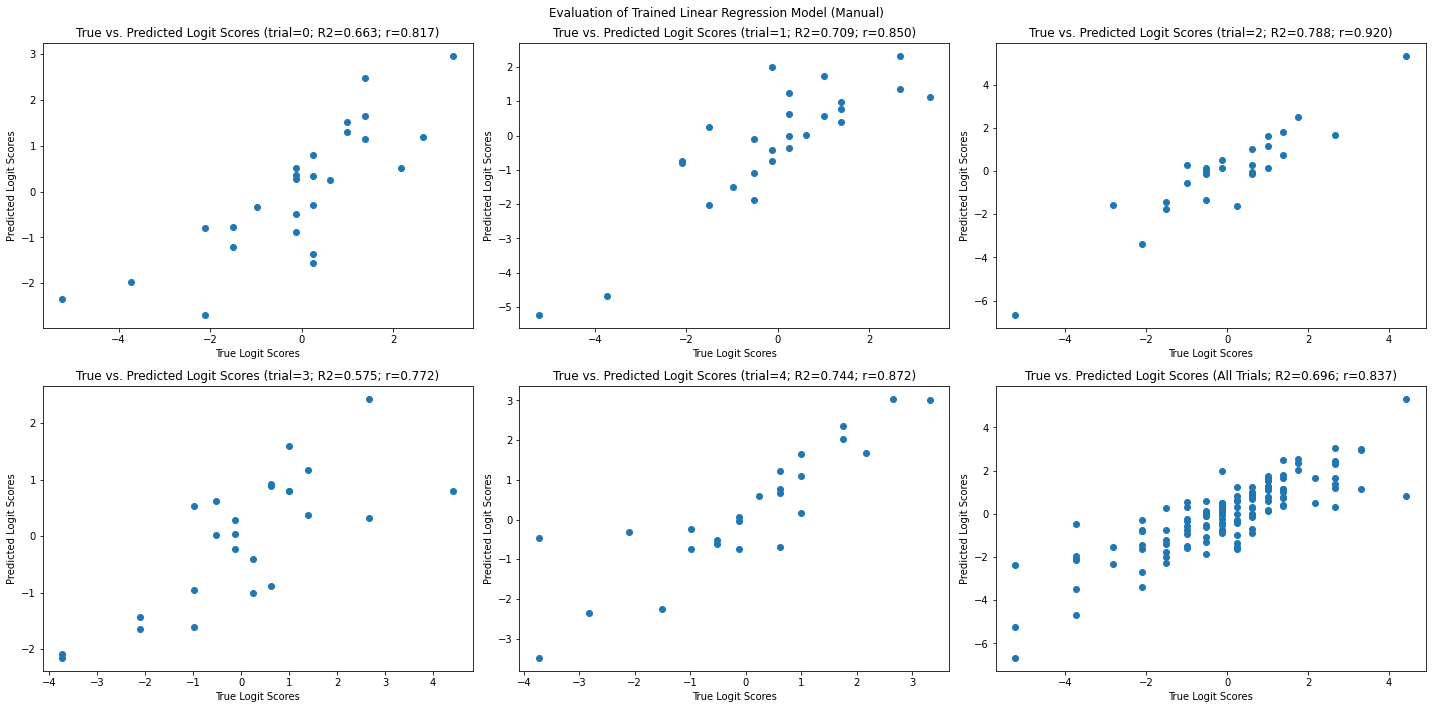

,R2,r
name,,
0 trial,0.662748,0.817080
1 trial,0.708693,0.850426
2 trial,0.787649,0.919893
3 trial,0.575055,0.771854
4 trial,0.743983,0.872465
Average,0.695626,0.846344
Concat,0.696235,0.837002


In [7]:
results = train(X, Y)
evaluate(task, results, manual)

**Automatic Measures**

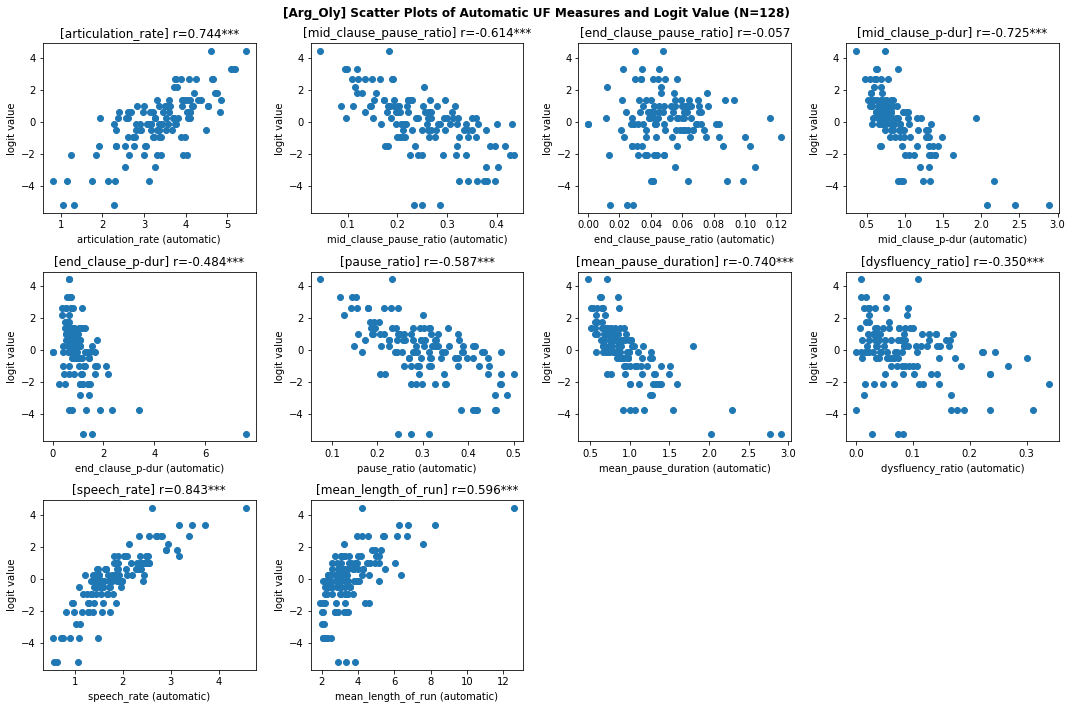

,r,p,sig
UF measures,,,
articulation_rate,0.743977,8.227291e-24,***
mid_clause_pause_ratio,-0.614126,1.268653e-14,***
end_clause_pause_ratio,-0.057377,5.200255e-01,
mid_clause_p-dur,-0.724751,4.019848e-22,***
end_clause_p-dur,-0.483885,7.192880e-09,***
pause_ratio,-0.586838,3.351903e-13,***
mean_pause_duration,-0.740007,1.888650e-23,***
dysfluency_ratio,-0.349771,5.188150e-05,***
speech_rate,0.842626,1.130142e-35,***


In [8]:
task = "Arg_Oly"
manual = False
X, Y = load_dataset(task, manual)
correlation_analysis(task, X, Y, manual)

[0] R2 = 0.7928286012035639
[1] R2 = 0.8020162479368935
[2] R2 = 0.7741701608332904
[3] R2 = 0.8216363476968241
[4] R2 = 0.8088447517246125


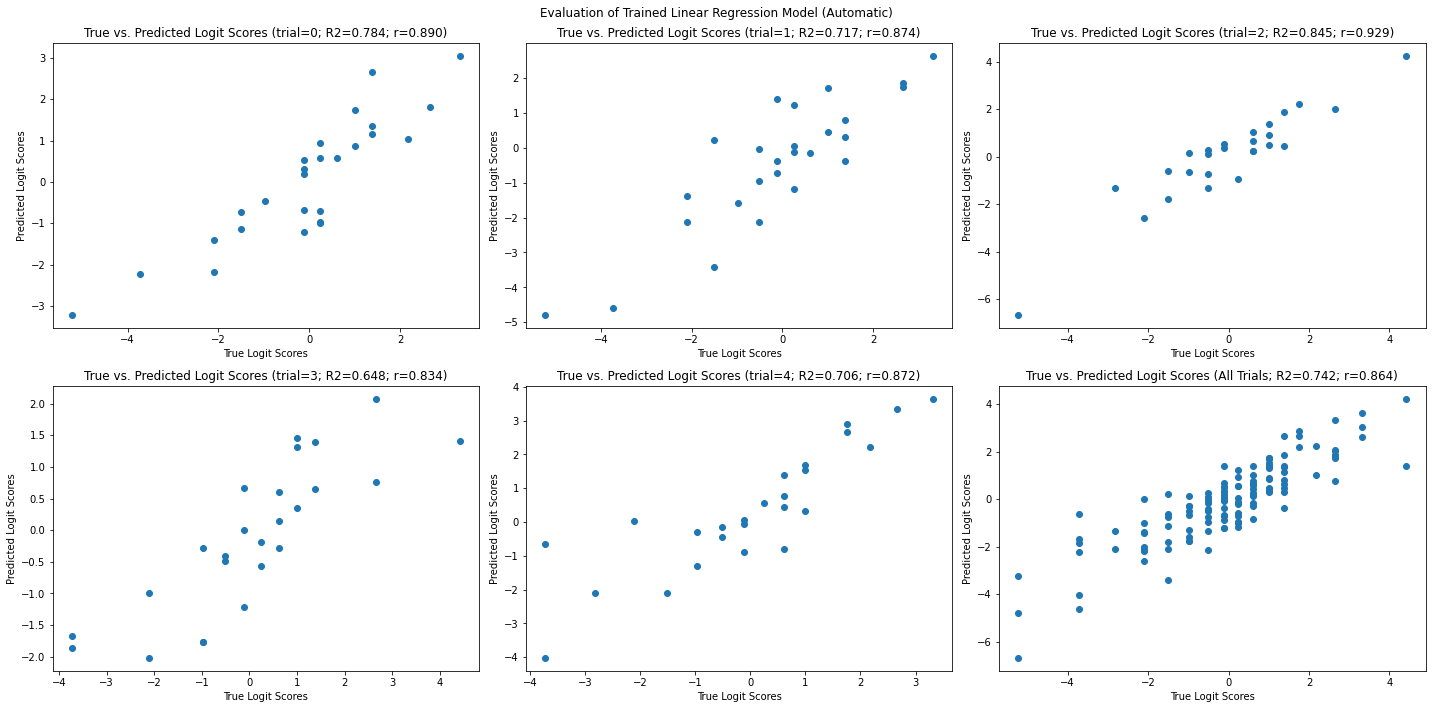

,R2,r
name,,
0 trial,0.784141,0.890119
1 trial,0.716671,0.874205
2 trial,0.845039,0.928793
3 trial,0.648448,0.833871
4 trial,0.706024,0.872457
Average,0.740065,0.879889
Concat,0.741599,0.863533


In [9]:
results = train(X, Y)
evaluate(task, results, manual)

### 3.2. Cartoon

**Manual Measures**

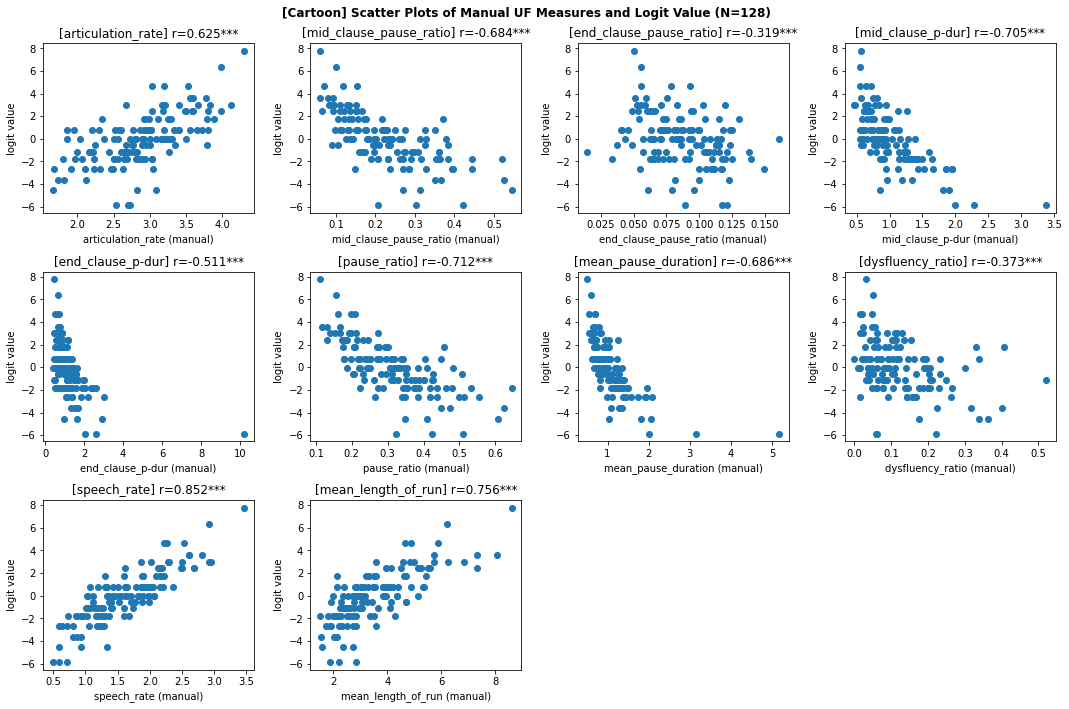

,r,p,sig
UF measures,,,
articulation_rate,0.625416,2.978254e-15,***
mid_clause_pause_ratio,-0.684250,5.422268e-19,***
end_clause_pause_ratio,-0.319443,2.374664e-04,***
mid_clause_p-dur,-0.705371,1.472384e-20,***
end_clause_p-dur,-0.511329,6.930026e-10,***
pause_ratio,-0.711815,4.596044e-21,***
mean_pause_duration,-0.685528,4.396623e-19,***
dysfluency_ratio,-0.372952,1.453907e-05,***
speech_rate,0.852206,2.963526e-37,***


In [10]:
task = "Cartoon"
manual = True
X, Y = load_dataset(task, manual)
correlation_analysis(task, X, Y, manual)

/home/matsuura/Applications/anaconda3/envs/teai-incremental-classifier/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[0] R2 = 0.7881866093505334
[1] R2 = 0.7634626132434391
[2] R2 = 0.7970978061258062
[3] R2 = 0.8069123269657522
[4] R2 = 0.7819487050661026


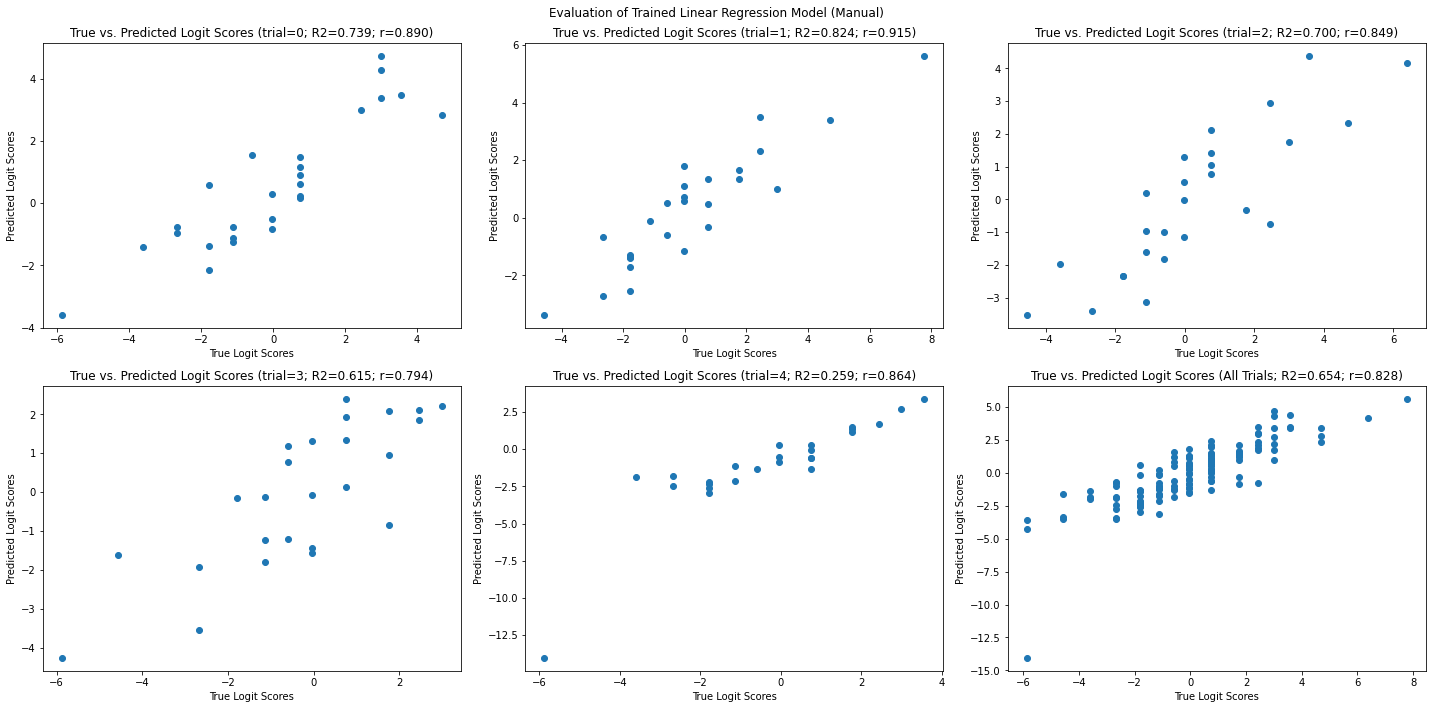

,R2,r
name,,
0 trial,0.739095,0.889999
1 trial,0.823823,0.915076
2 trial,0.700380,0.848743
3 trial,0.615370,0.794309
4 trial,0.259125,0.864479
Average,0.627559,0.862521
Concat,0.653741,0.828452


In [11]:
results = train(X, Y)
evaluate(task, results, manual)

**Automatic Measures**

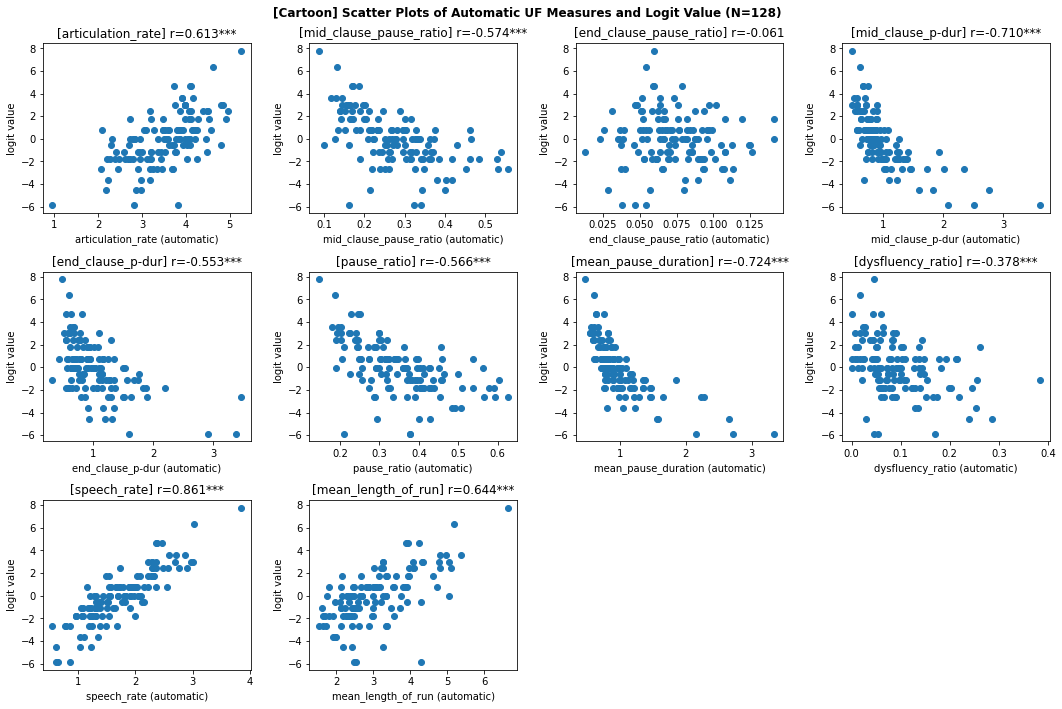

,r,p,sig
UF measures,,,
articulation_rate,0.612759,1.505959e-14,***
mid_clause_pause_ratio,-0.573952,1.418196e-12,***
end_clause_pause_ratio,-0.060576,4.969825e-01,
mid_clause_p-dur,-0.709880,6.541018e-21,***
end_clause_p-dur,-0.552535,1.363167e-11,***
pause_ratio,-0.565884,3.390297e-12,***
mean_pause_duration,-0.723555,5.064672e-22,***
dysfluency_ratio,-0.377565,1.115420e-05,***
speech_rate,0.860955,8.449894e-39,***


In [12]:
task = "Cartoon"
manual = False
X, Y = load_dataset(task, manual)
correlation_analysis(task, X, Y, manual)

/home/matsuura/Applications/anaconda3/envs/teai-incremental-classifier/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[0] R2 = 0.8099433189532732
[1] R2 = 0.7714977922346826
[2] R2 = 0.8164227867247714
[3] R2 = 0.8017454482095823
[4] R2 = 0.7739344317515573


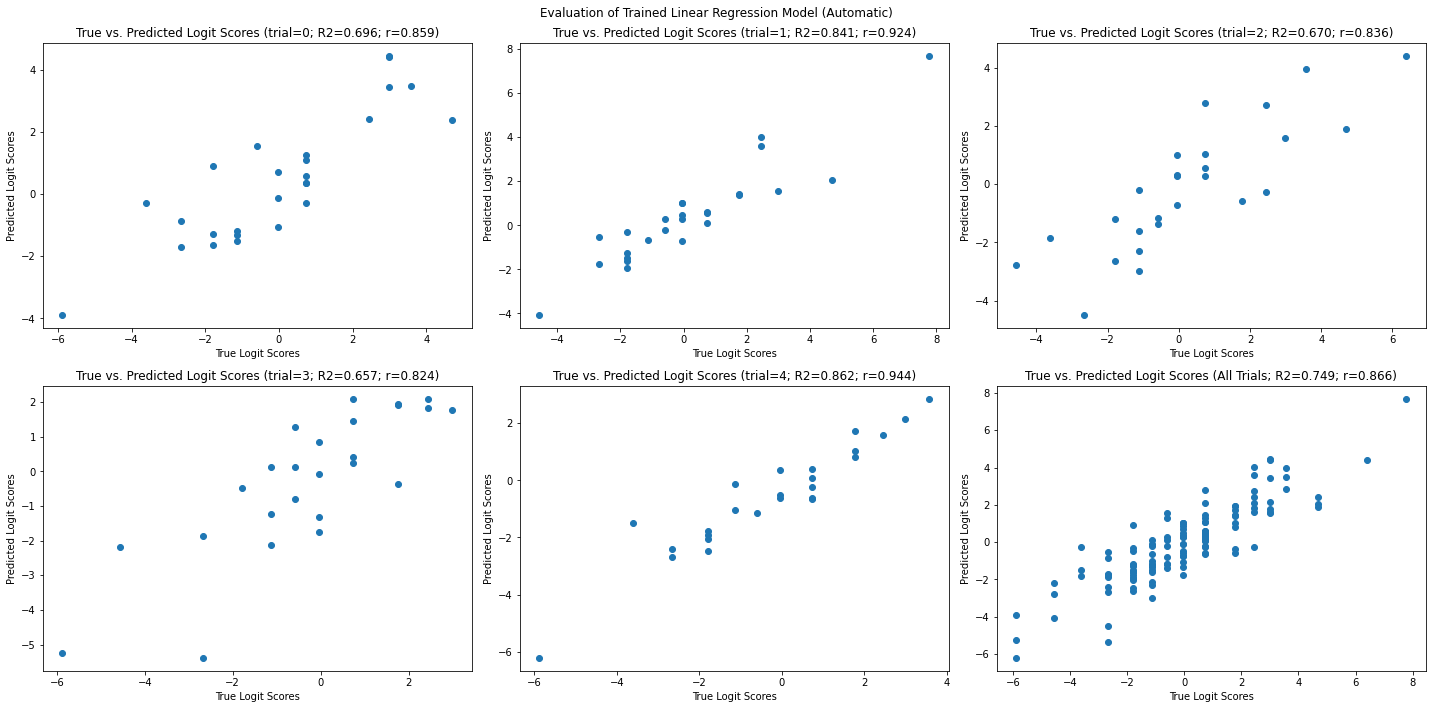

,R2,r
name,,
0 trial,0.696053,0.858926
1 trial,0.841199,0.923715
2 trial,0.669600,0.835502
3 trial,0.657032,0.823892
4 trial,0.861779,0.943602
Average,0.745133,0.877127
Concat,0.748745,0.866058


In [13]:
results = train(X, Y)
evaluate(task, results, manual)

### 3.3. RtSwithoutRAA

**Manual Measures**

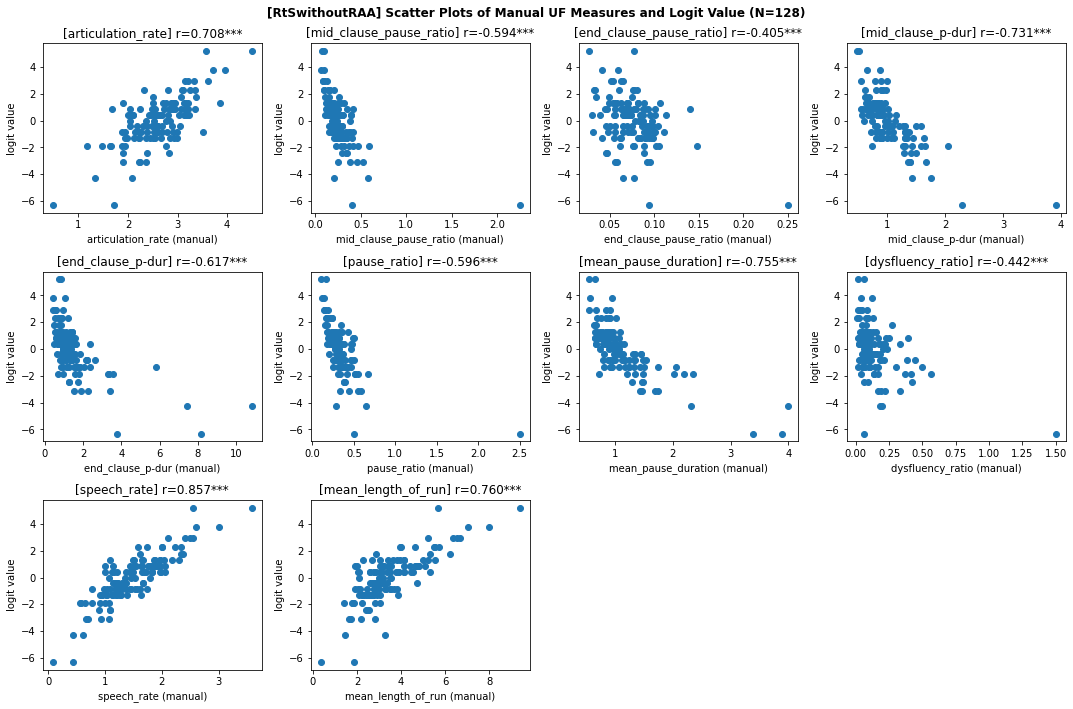

,r,p,sig
UF measures,,,
articulation_rate,0.707646,9.796397e-21,***
mid_clause_pause_ratio,-0.593659,1.521835e-13,***
end_clause_pause_ratio,-0.404772,2.148005e-06,***
mid_clause_p-dur,-0.730656,1.261558e-22,***
end_clause_p-dur,-0.616619,9.258499e-15,***
pause_ratio,-0.595654,1.203669e-13,***
mean_pause_duration,-0.754729,8.007664e-25,***
dysfluency_ratio,-0.441735,1.792429e-07,***
speech_rate,0.857058,4.243054e-38,***


In [14]:
task = "RtSwithoutRAA"
manual = True
X, Y = load_dataset(task, manual)
correlation_analysis(task, X, Y, manual)

/home/matsuura/Applications/anaconda3/envs/teai-incremental-classifier/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[0] R2 = 0.8174584762662882
[1] R2 = 0.8038706929977142
[2] R2 = 0.7956012154743497
[3] R2 = 0.8023162432548945
[4] R2 = 0.8267701916823899


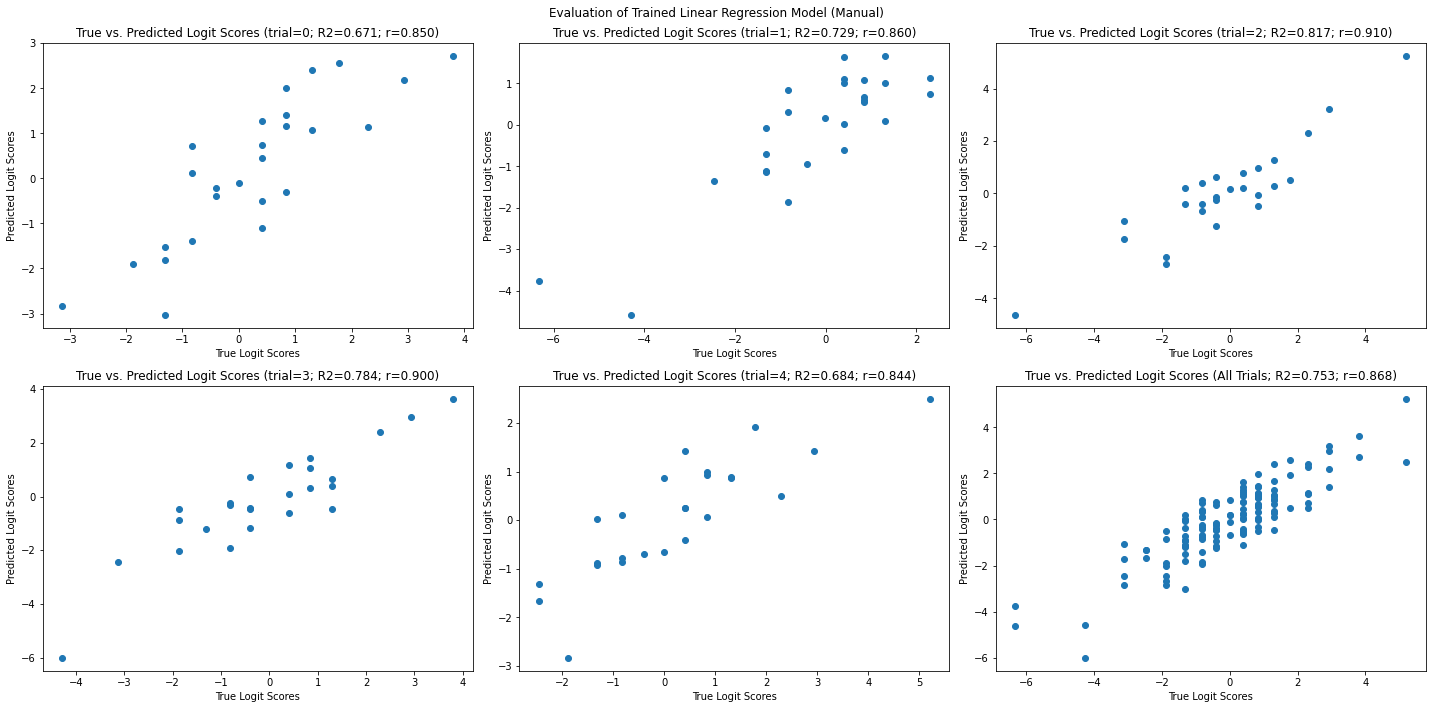

,R2,r
name,,
0 trial,0.671440,0.850224
1 trial,0.729456,0.859720
2 trial,0.817179,0.909931
3 trial,0.784192,0.899912
4 trial,0.683658,0.844068
Average,0.737185,0.872771
Concat,0.752719,0.867877


In [15]:
results = train(X, Y)
evaluate(task, results, manual)

**Automatic Measures**

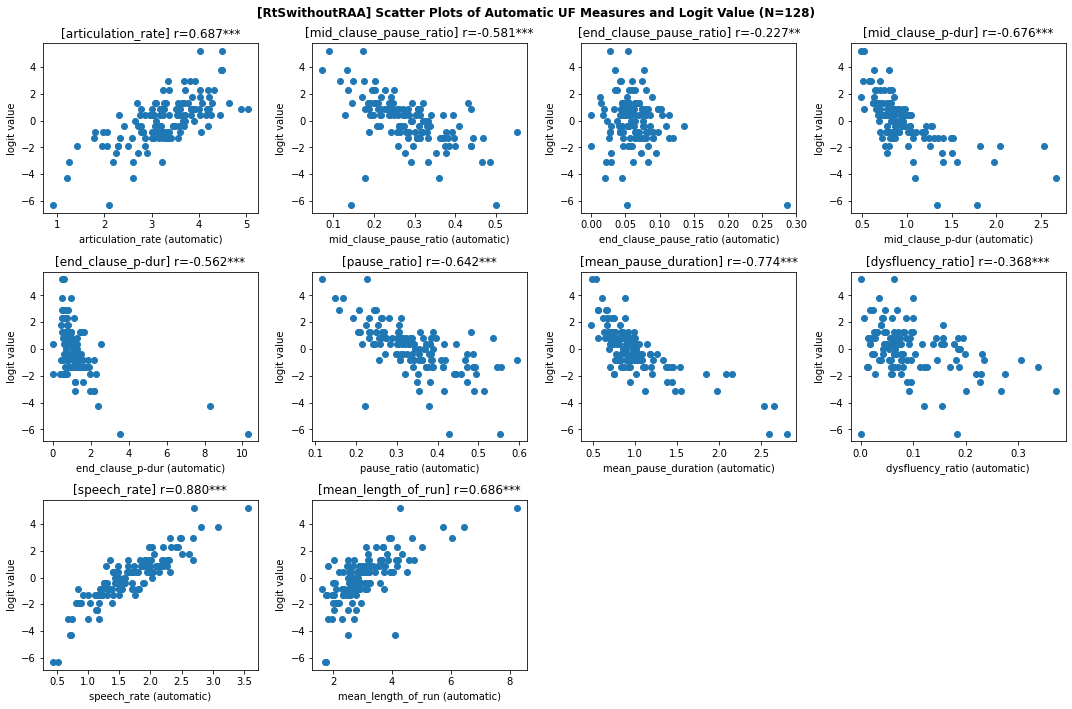

,r,p,sig
UF measures,,,
articulation_rate,0.687414,3.221056e-19,***
mid_clause_pause_ratio,-0.581083,6.433301e-13,***
end_clause_pause_ratio,-0.227178,9.913779e-03,**
mid_clause_p-dur,-0.676311,1.946307e-18,***
end_clause_p-dur,-0.561837,5.203693e-12,***
pause_ratio,-0.641717,3.302856e-16,***
mean_pause_duration,-0.773501,1.013421e-26,***
dysfluency_ratio,-0.367778,1.947896e-05,***
speech_rate,0.880160,1.353881e-42,***


In [16]:
task = "RtSwithoutRAA"
manual = False
X, Y = load_dataset(task, manual)
correlation_analysis(task, X, Y, manual)

/home/matsuura/Applications/anaconda3/envs/teai-incremental-classifier/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[0] R2 = 0.8504032372737813
[1] R2 = 0.8324676672168472
[2] R2 = 0.8281299754064001
[3] R2 = 0.8477938660509681
[4] R2 = 0.8590888396181886


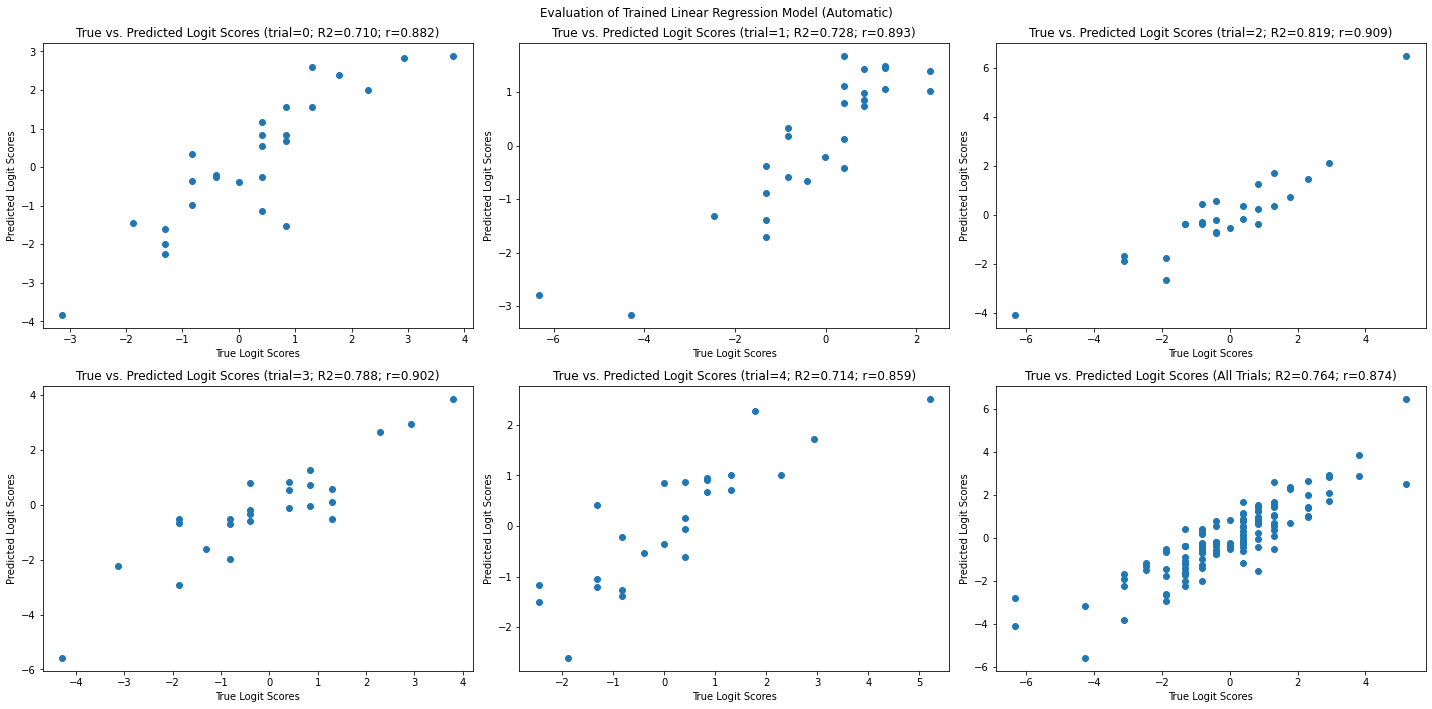

,R2,r
name,,
0 trial,0.709980,0.881626
1 trial,0.728245,0.892681
2 trial,0.819293,0.909477
3 trial,0.788189,0.901744
4 trial,0.714156,0.859019
Average,0.751973,0.888909
Concat,0.764165,0.874397


In [17]:
results = train(X, Y)
evaluate(task, results, manual)

### 3.4. RtSwithRAA

**Manual Measures**

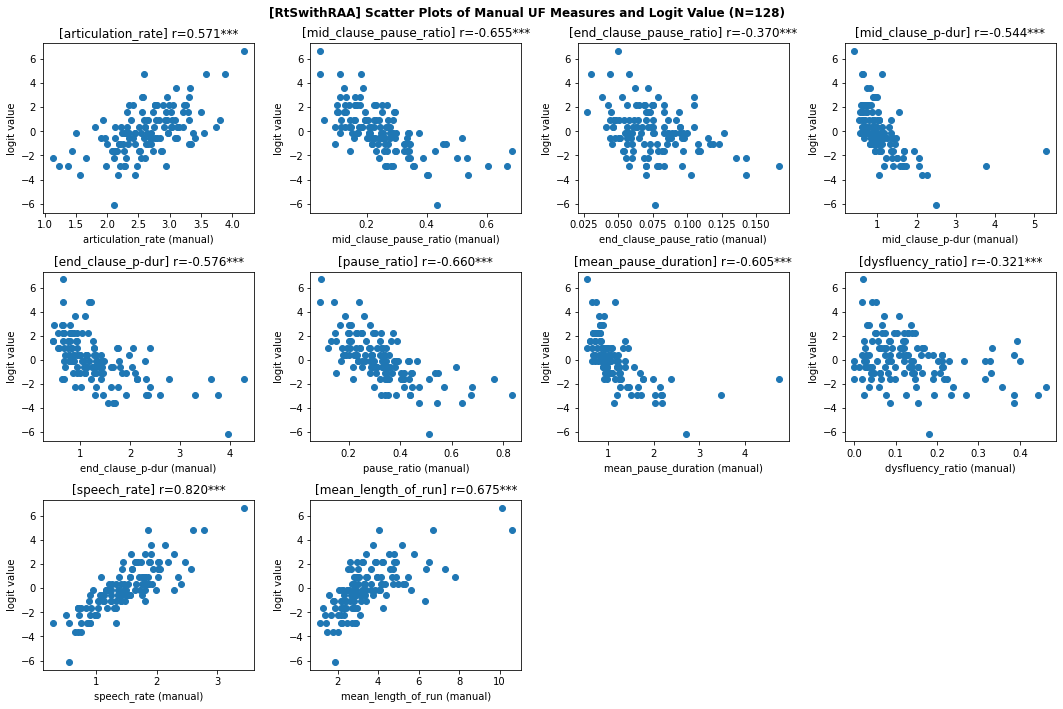

,r,p,sig
UF measures,,,
articulation_rate,0.571047,1.946264e-12,***
mid_clause_pause_ratio,-0.654776,5.144129e-17,***
end_clause_pause_ratio,-0.369885,1.730162e-05,***
mid_clause_p-dur,-0.544019,3.208413e-11,***
end_clause_p-dur,-0.575704,1.169917e-12,***
pause_ratio,-0.660276,2.286602e-17,***
mean_pause_duration,-0.605303,3.783812e-14,***
dysfluency_ratio,-0.320590,2.248279e-04,***
speech_rate,0.819913,2.594754e-32,***


In [18]:
task = "RtSwithRAA"
manual = True
X, Y = load_dataset(task, manual)
correlation_analysis(task, X, Y, manual)

/home/matsuura/Applications/anaconda3/envs/teai-incremental-classifier/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[0] R2 = 0.7740324657410582
[1] R2 = 0.7621419981107335
[2] R2 = 0.7326060036933333
[3] R2 = 0.7231737139587155
[4] R2 = 0.7468316532718963


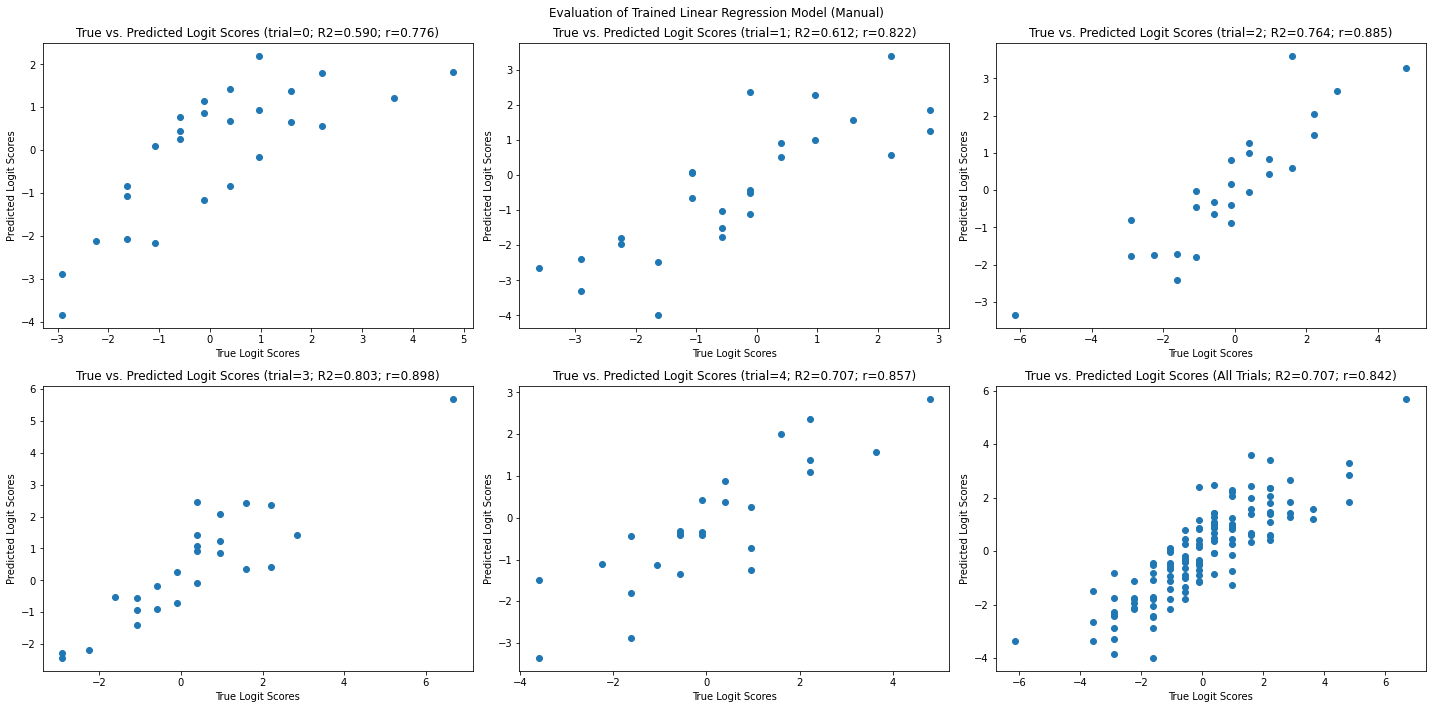

,R2,r
name,,
0 trial,0.590241,0.775541
1 trial,0.612037,0.822252
2 trial,0.764471,0.884971
3 trial,0.802706,0.898140
4 trial,0.706839,0.856796
Average,0.695259,0.847540
Concat,0.707416,0.841820


In [19]:
results = train(X, Y)
evaluate(task, results, manual)

**Automatic Measures**

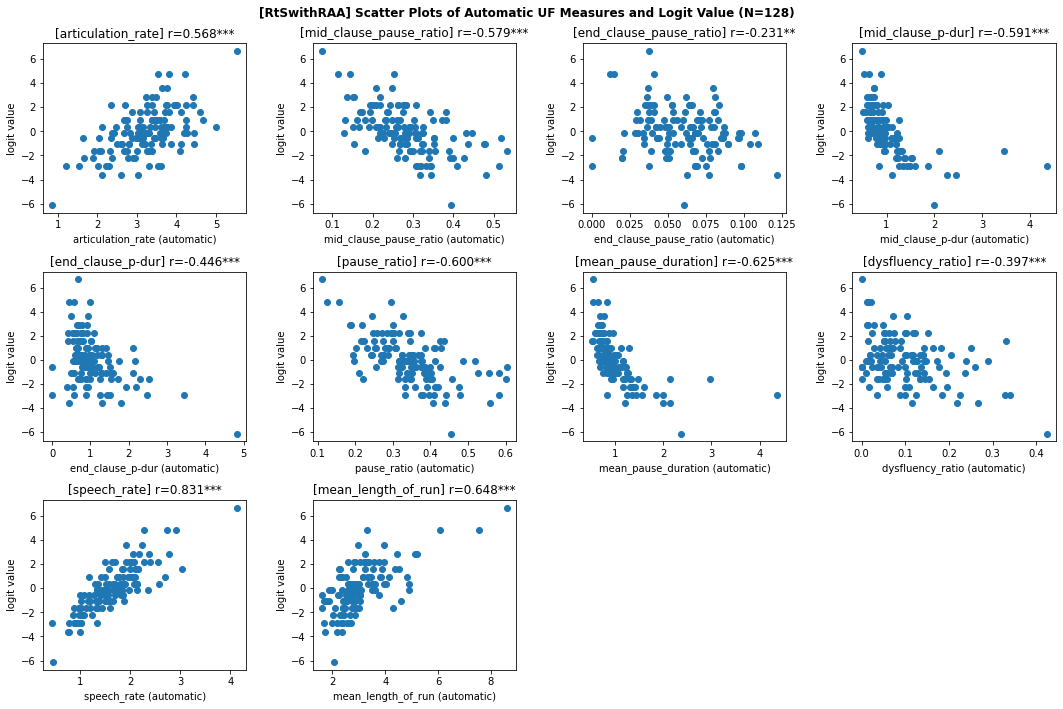

,r,p,sig
UF measures,,,
articulation_rate,0.568191,2.648758e-12,***
mid_clause_pause_ratio,-0.578684,8.411201e-13,***
end_clause_pause_ratio,-0.230926,8.727659e-03,**
mid_clause_p-dur,-0.590834,2.115092e-13,***
end_clause_p-dur,-0.445985,1.321353e-07,***
pause_ratio,-0.600189,7.020924e-14,***
mean_pause_duration,-0.624923,3.176524e-15,***
dysfluency_ratio,-0.397249,3.437366e-06,***
speech_rate,0.830991,6.876477e-34,***


In [20]:
task = "RtSwithRAA"
manual = False
X, Y = load_dataset(task, manual)
correlation_analysis(task, X, Y, manual)

/home/matsuura/Applications/anaconda3/envs/teai-incremental-classifier/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[0] R2 = 0.7961981566334355
[1] R2 = 0.7541521307445688
[2] R2 = 0.7448014257644221
[3] R2 = 0.7294399781342518
[4] R2 = 0.7598279056232545


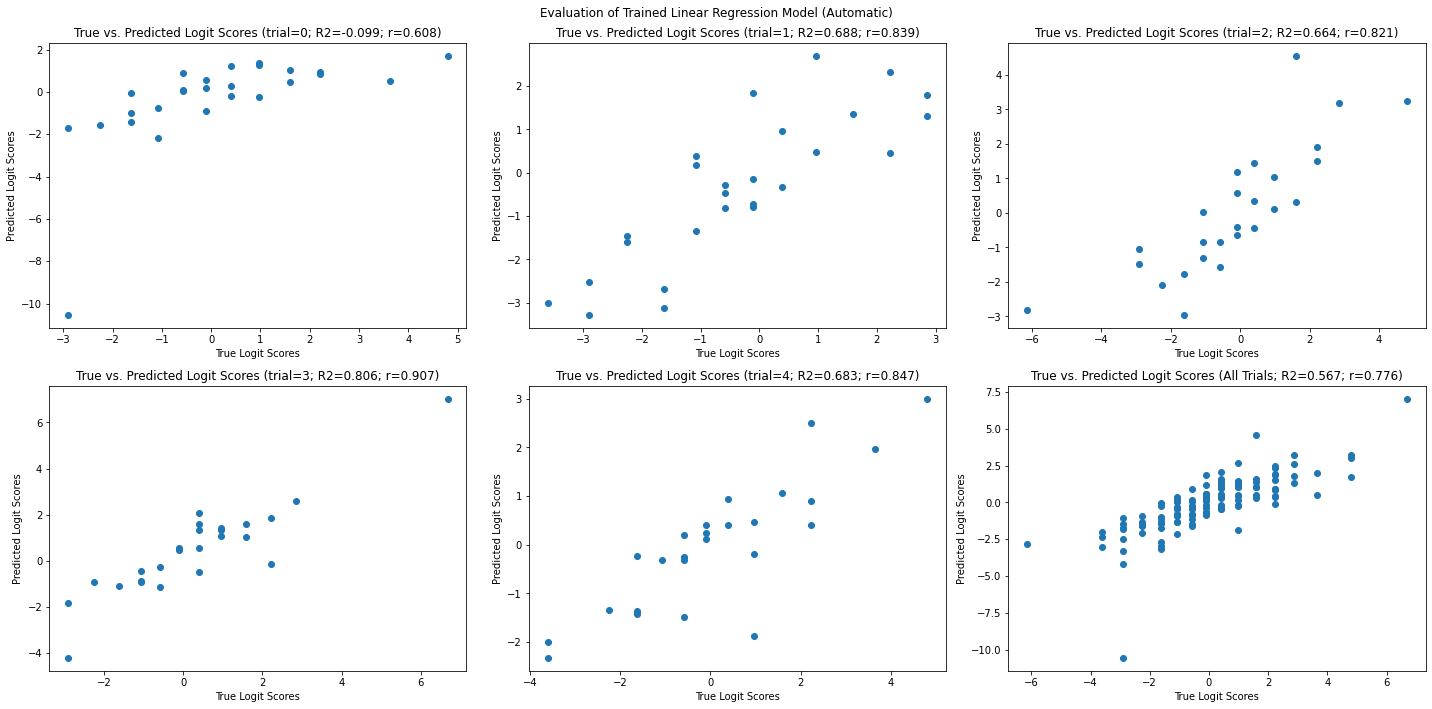

,R2,r
name,,
0 trial,-0.099360,0.607714
1 trial,0.687566,0.839254
2 trial,0.663620,0.820655
3 trial,0.805897,0.907392
4 trial,0.682938,0.847047
Average,0.548132,0.804413
Concat,0.566663,0.776008


In [21]:
results = train(X, Y)
evaluate(task, results, manual)

### 3.5. WoZ Interview

**Manual Measures**

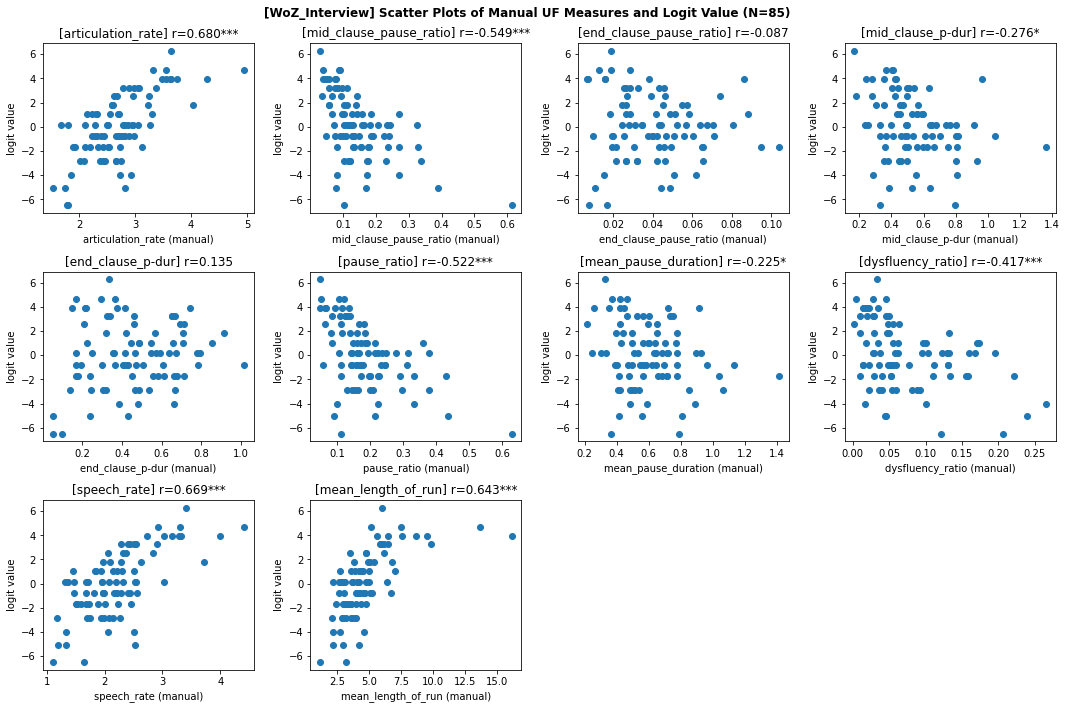

,r,p,sig
UF measures,,,
articulation_rate,0.680320,7.982105e-13,***
mid_clause_pause_ratio,-0.549138,5.270314e-08,***
end_clause_pause_ratio,-0.086843,4.293571e-01,
mid_clause_p-dur,-0.276029,1.055599e-02,*
end_clause_p-dur,0.135394,2.166478e-01,
pause_ratio,-0.521800,3.037354e-07,***
mean_pause_duration,-0.224698,3.869102e-02,*
dysfluency_ratio,-0.417166,7.132862e-05,***
speech_rate,0.669202,2.543385e-12,***


In [22]:
task = "WoZ_Interview"
manual = True
X, Y = load_dataset(task, manual)
correlation_analysis(task, X, Y, manual)

/home/matsuura/Applications/anaconda3/envs/teai-incremental-classifier/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[0] R2 = 0.6661102355321984
[1] R2 = 0.6324875973366453
[2] R2 = 0.6698566171597353
[3] R2 = 0.6754391872035082
[4] R2 = 0.6420592854220191


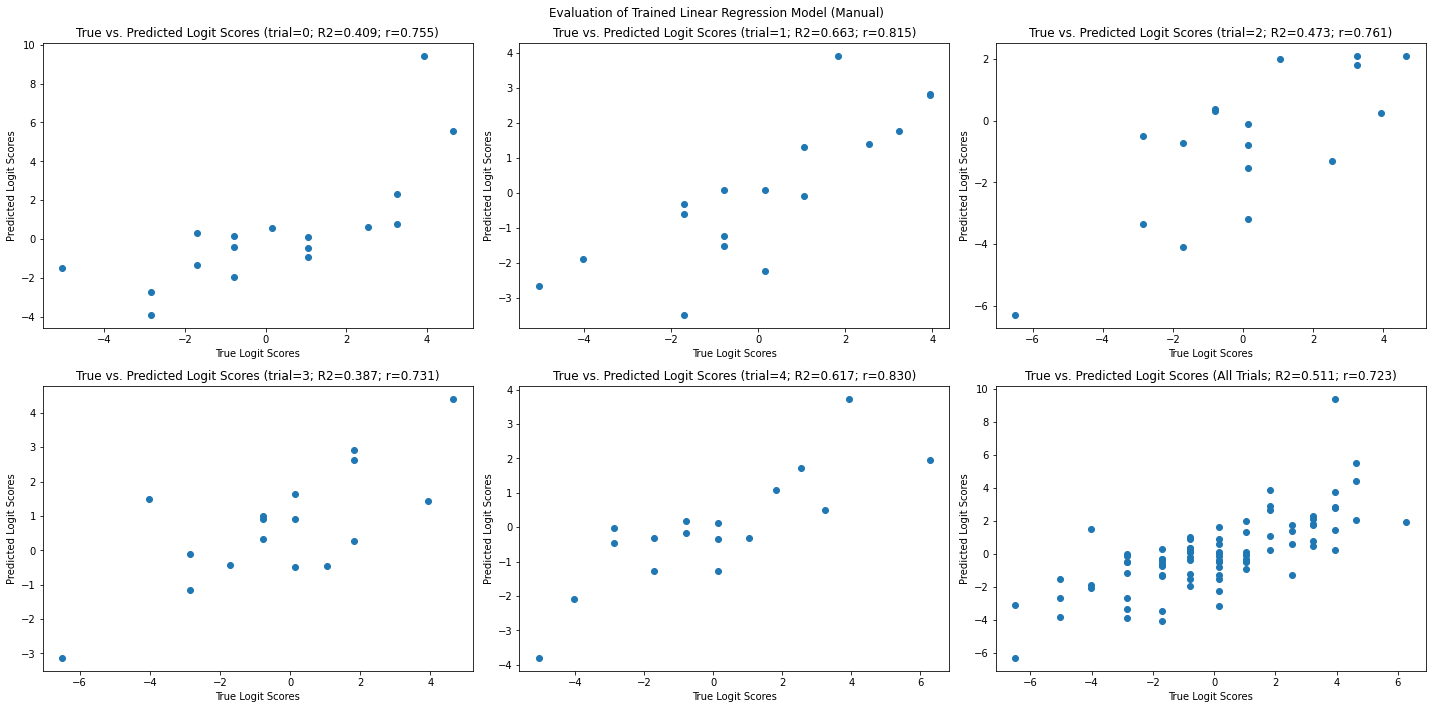

,R2,r
name,,
0 trial,0.408867,0.755496
1 trial,0.663164,0.814779
2 trial,0.472821,0.760811
3 trial,0.387117,0.731163
4 trial,0.616980,0.829570
Average,0.509790,0.778364
Concat,0.510795,0.722604


In [23]:
results = train(X, Y)
evaluate(task, results, manual)

**Automatic Measures**

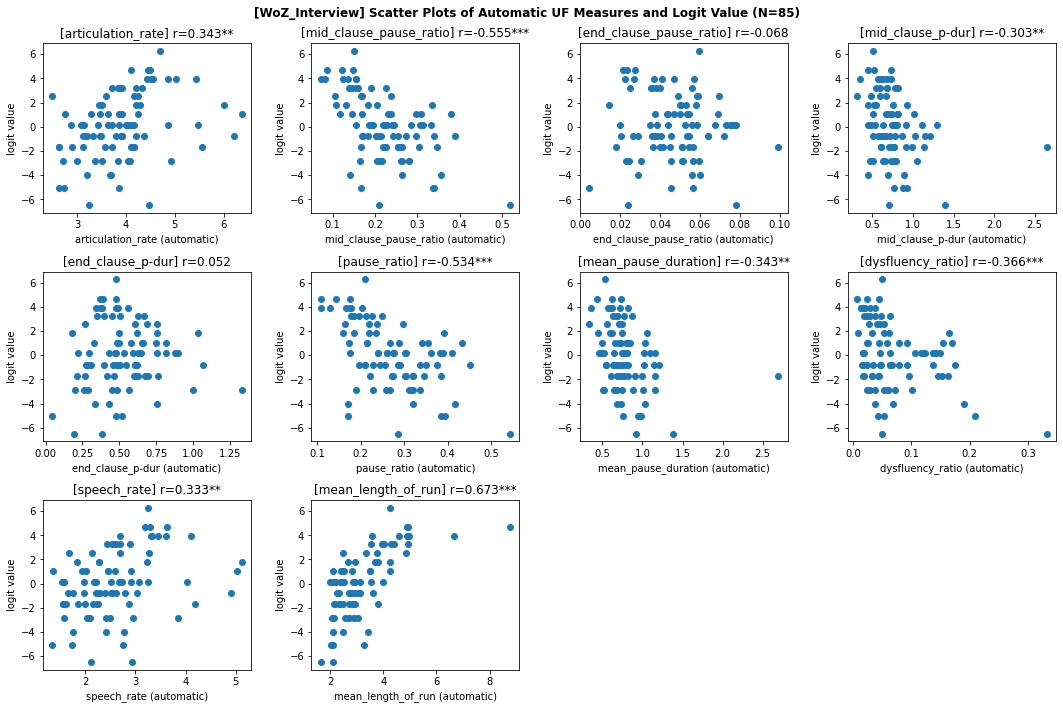

,r,p,sig
UF measures,,,
articulation_rate,0.343205,1.301686e-03,**
mid_clause_pause_ratio,-0.555233,3.489938e-08,***
end_clause_pause_ratio,-0.067940,5.366995e-01,
mid_clause_p-dur,-0.302945,4.829262e-03,**
end_clause_p-dur,0.051954,6.367684e-01,
pause_ratio,-0.533817,1.433475e-07,***
mean_pause_duration,-0.343068,1.307887e-03,**
dysfluency_ratio,-0.365968,5.723096e-04,***
speech_rate,0.332818,1.856788e-03,**


In [24]:
task = "WoZ_Interview"
manual = False
X, Y = load_dataset(task, manual)
correlation_analysis(task, X, Y, manual)

/home/matsuura/Applications/anaconda3/envs/teai-incremental-classifier/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[0] R2 = 0.6766729014557927
[1] R2 = 0.5948591347935299
[2] R2 = 0.6554285789483825
[3] R2 = 0.5944243524887989
[4] R2 = 0.634547920964488


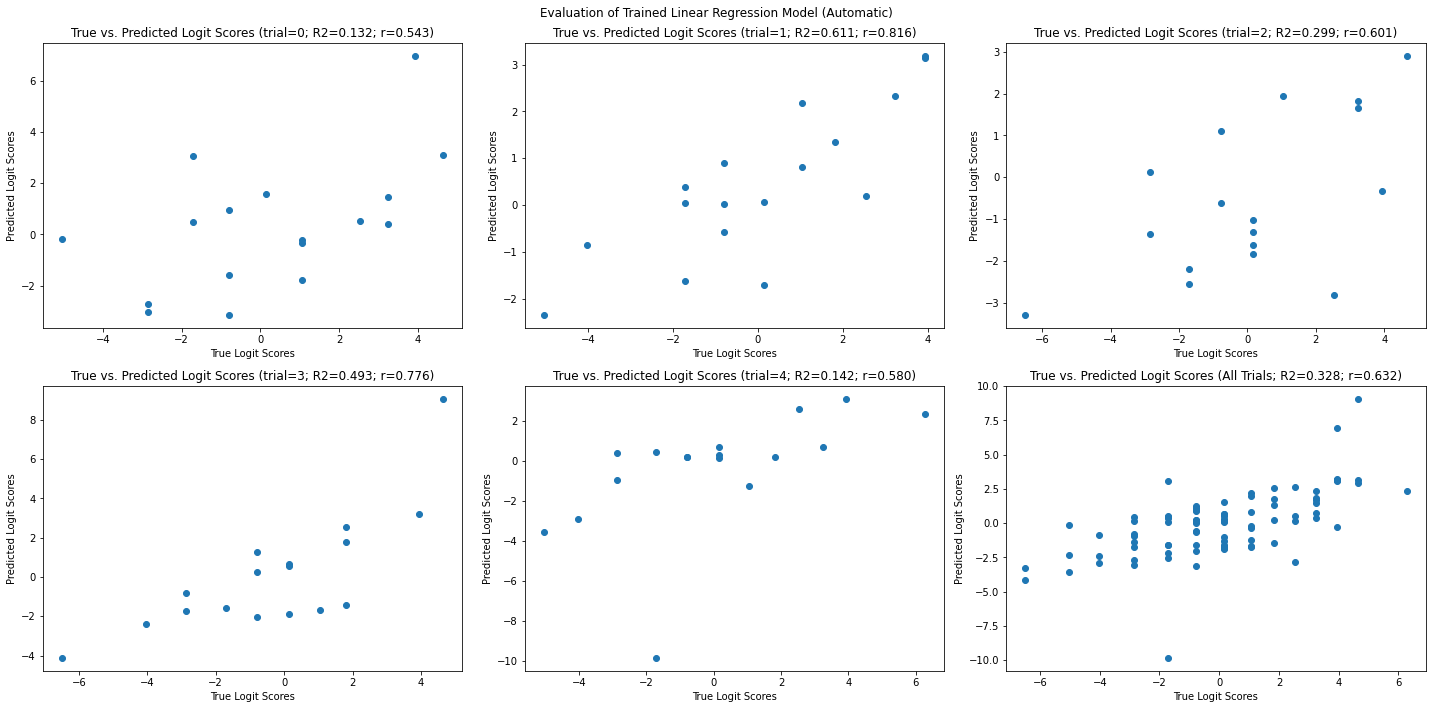

,R2,r
name,,
0 trial,0.131988,0.543204
1 trial,0.611437,0.816000
2 trial,0.299481,0.601295
3 trial,0.492877,0.775511
4 trial,0.142256,0.580119
Average,0.335608,0.663226
Concat,0.327812,0.631748


In [25]:
results = train(X, Y)
evaluate(task, results, manual)